# Import

In [1]:
# Basic
import pandas as pd
import numpy as np

import warnings
warnings.simplefilter('ignore')

# Dataset
from sklearn.datasets import make_moons, load_boston

# ML Toolkit
from robusta.crossval import crossval, rating_table

# Model
from robusta.calibration import CalibratedClassifierCV
from robusta.testing import all_models

# Plot
from jupyterthemes import jtplot
import seaborn as sns
import matplotlib

jtplot.style('gruvboxd')
matplotlib.use('nbagg')

Using TensorFlow backend.


# Correlations

In [2]:
def plot_corr_matrix(results, cmap='icefire', method='kendall', n_digits=2, **kwargs):
    
    idx_list = results.keys()
    model_names = [result['model_name'] for result in results.values()]
    for idx, model_name in zip(idx_list, model_names):
        print('[{}] {}'.format(idx, model_name))
    
    preds = [result['oof_pred'] for result in results.values()]
    preds = pd.concat(preds, axis=1)
    preds.columns = idx_list

    corr = preds.corr(method).round(n_digits)
    corr = corr.groupby(corr.index).mean().loc[idx_list]
    
    ax = sns.heatmap(corr, annot=True, cmap=cmap, center=0, **kwargs)
    return ax

# All Classifiers

In [3]:
X, y = make_moons(200, noise=0.2)

X = pd.DataFrame(X)
y = pd.Series(y)

X

,0,1
0,0.866950,0.147588
1,-0.384041,0.823723
2,-0.810435,0.281841
3,0.345965,0.176415
4,0.166309,-0.279917
...,...,...
195,1.815104,-0.194080
196,-0.789367,0.445480
197,0.508053,-0.244677
198,0.133217,1.263021


In [4]:
scoring = 'roc_auc'
cv = 5

In [7]:
BLACKLIST = ['RVM', 'Blend', 'CatBoost']

results = {}

for model_dict in all_models(['classifier']):
    
    try:
        clf = model_dict['class']() # default params
        name = model_dict['name']
    except:
        continue
    
    if name in BLACKLIST:
        continue
    
    if not hasattr(clf, 'predict_proba'):
        if hasattr(clf, 'decision_function'):
            clf = CalibratedClassifierCV(clf)
        else:
            continue
    
    try:
        result = crossval(clf, cv, X, y, scoring=scoring, method='predict_proba',
                          verbose=2, n_jobs=-1, compact=True)
        result['model_name'] = name
        results[name] = result
        
    except:
        pass
    
idx_results = dict(zip(range(len(results)), results.values()))

0.9300    0.9350    0.9650    0.9750    0.9400    0.9490 ± 0.0177    [LogisticRegression]
0.9350    0.9300    0.9700    0.9775    0.9375    0.9500 ± 0.0197    [LogisticRegressionCV]
0.9275    0.9275    0.9700    0.9600    0.9475    0.9465 ± 0.0171    [CalibratedClassifierCV]
0.9300    0.9275    0.9775    0.9500    0.9400    0.9450 ± 0.0181    [CalibratedClassifierCV]
0.9325    0.9325    0.9650    0.9775    0.9400    0.9495 ± 0.0184    [CalibratedClassifierCV]
0.9325    0.9325    0.9650    0.9775    0.9400    0.9495 ± 0.0184    [CalibratedClassifierCV]
0.9325    0.9275    0.9650    0.9700    0.9400    0.9470 ± 0.0173    [CalibratedClassifierCV]
0.9775    0.9575    1.0000    0.9950    0.9775    0.9815 ± 0.0150    [CalibratedClassifierCV]
0.9775    0.9575    1.0000    0.9950    0.9775    0.9815 ± 0.0150    [CalibratedClassifierCV]
0.9775    0.9575    1.0000    0.9950    0.9775    0.9815 ± 0.0150    [CalibratedClassifierCV]
0.9350    0.9350    0.9675    0.9775    0.9400    0.9510 ± 0.0179 

In [8]:
top = rating_table(idx_results).sort_values('LOCAL', ascending=False)
top

,MODEL_NAME,PRIVATE,PUBLIC,LOCAL,STD,MIN,MAX
7,SVM,None,None,0.9815,0.0168,0.9575,1.0000
8,NuSVM,None,None,0.9815,0.0168,0.9575,1.0000
9,LinearSVM,None,None,0.9815,0.0168,0.9575,1.0000
17,GradientBoosting,None,None,0.9802,0.0189,0.9562,1.0000
12,KNeighbors,None,None,0.9760,0.0369,0.9162,1.0000
22,LGB,None,None,0.9758,0.0224,0.9438,1.0000
21,XGB,None,None,0.9752,0.0273,0.9450,1.0000
18,AdaBoost,None,None,0.9722,0.0278,0.9288,1.0000
13,GaussianProcess,None,None,0.9715,0.0221,0.9400,0.9950
15,ExtraTrees,None,None,0.9690,0.0267,0.9300,0.9975


[7] SVM
[8] NuSVM
[9] LinearSVM
[17] GradientBoosting
[12] KNeighbors
[22] LGB
[21] XGB
[18] AdaBoost
[13] GaussianProcess
[15] ExtraTrees


<IPython.core.display.Javascript object>


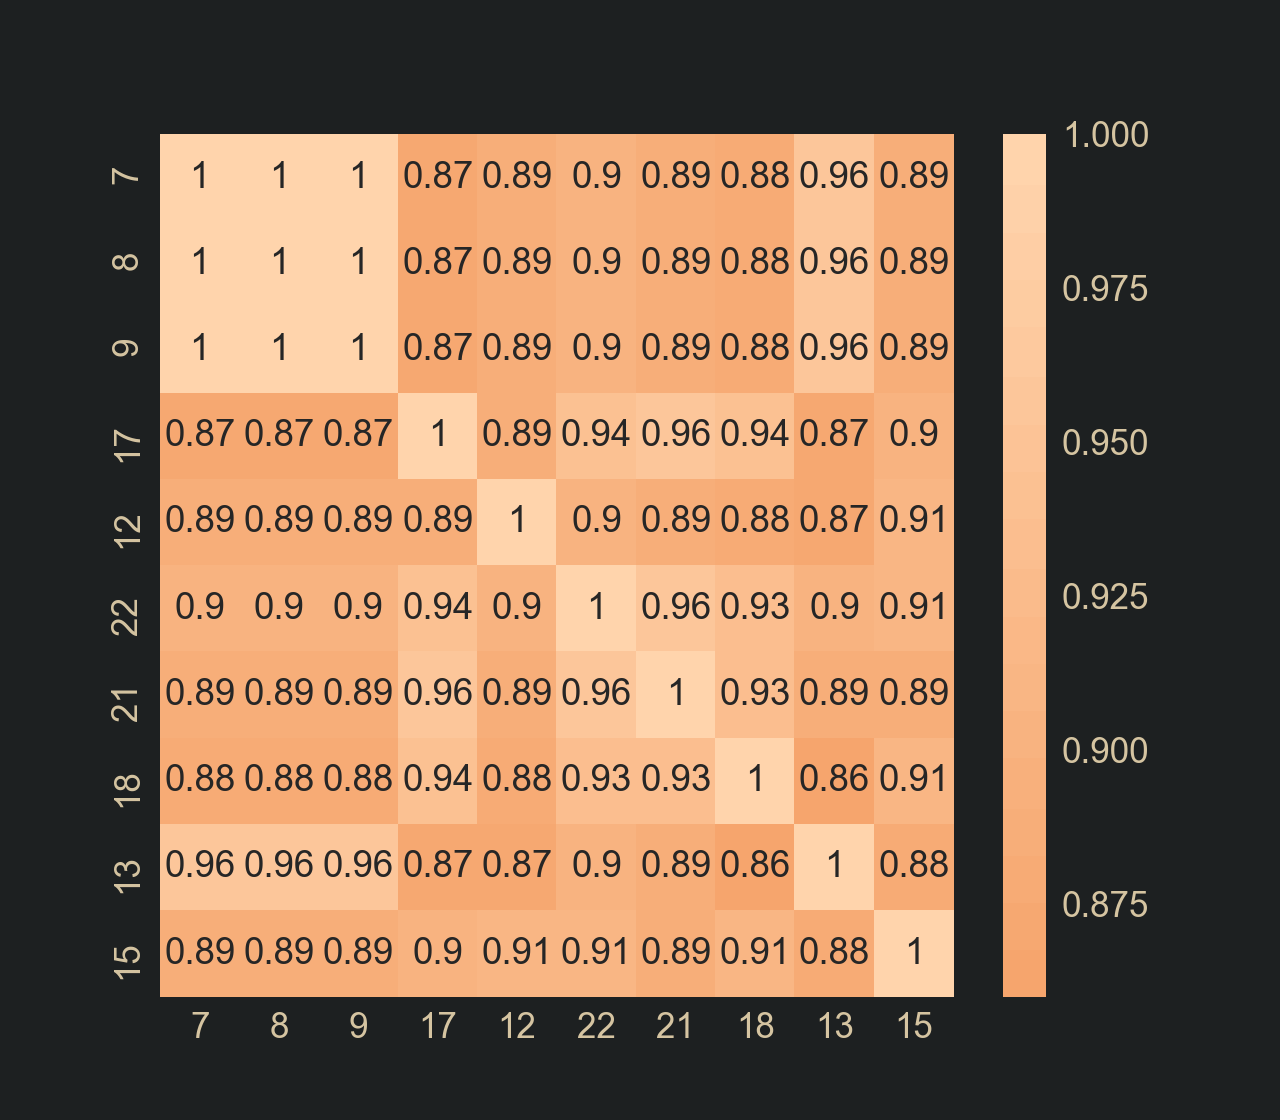

In [9]:
%matplotlib notebook

K_TOP = 10

top_results = {i: idx_results[i] for i in top.index[:K_TOP]}
ax = plot_corr_matrix(top_results, method='spearman')

# All Regressors

In [10]:
X, y = load_boston(return_X_y=True)

X = pd.DataFrame(X)
y = pd.Series(y)

X

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48


In [11]:
scoring = 'neg_mean_squared_error'
cv = 5

In [12]:
BLACKLIST = ['RVM', 'Blend', 'CatBoost', 'RANSAC', 'SGD', 'BART']

results = {}

for model_dict in all_models(['regressor']):
    
    try:
        reg = model_dict['class']() # default params
        name = model_dict['name']
    except:
        continue
    
    if name in BLACKLIST or 'MultiTask' in name:
        continue
    
    try:
        result = crossval(reg, cv, X, y, scoring=scoring, method='predict',
                          verbose=2, n_jobs=-1)
        result['model_name'] = name
        results[name] = result
        
    except:
        pass
    
idx_results = dict(zip(range(len(results)), results.values()))

[18:34:19]  ARDRegression

[18:34:20]  FOLD  0:   -12.0781
[18:34:20]  FOLD  1:   -27.9411
[18:34:20]  FOLD  2:   -34.6298
[18:34:20]  FOLD  3:   -82.4508
[18:34:20]  FOLD  4:   -30.0944

[18:34:20]  AVERAGE:   -37.4388 ± 23.7541

[18:34:20]  BayesianRidge

[18:34:20]  FOLD  0:   -11.5812
[18:34:20]  FOLD  1:   -24.7569
[18:34:20]  FOLD  2:   -30.5592
[18:34:20]  FOLD  3:   -79.6687
[18:34:20]  FOLD  4:   -28.3731

[18:34:21]  AVERAGE:   -34.9878 ± 23.2907

[18:34:21]  ElasticNet

[18:34:21]  FOLD  0:   -14.8425
[18:34:21]  FOLD  1:   -30.7088
[18:34:21]  FOLD  2:   -47.7941
[18:34:21]  FOLD  3:   -47.4693
[18:34:21]  FOLD  4:   -19.4537

[18:34:21]  AVERAGE:   -32.0537 ± 13.7273

[18:34:21]  ElasticNetCV

[18:34:21]  FOLD  0:   -18.7250
[18:34:21]  FOLD  1:   -33.2299
[18:34:21]  FOLD  2:   -56.1521
[18:34:21]  FOLD  3:   -47.0278
[18:34:21]  FOLD  4:   -19.7299

[18:34:21]  AVERAGE:   -34.9729 ± 14.7869

[18:34:21]  HuberRegressor

[18:34:22]  FOLD  0:   -9.3535
[18:34:22]  FOLD  1: 

/Users/pechyonkinb/anaconda/lib/python3.6/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/Users/pechyonkinb/anaconda/lib/python3.6/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/Users/pechyonkinb/anaconda/lib/python3.6/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/Users/pechyonkinb/anaconda/lib/python3.6/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
/Users/pechyonkinb/anaconda/lib/python3.6/site-packages/sklearn/neighbors/regression.py:327: UserWarning: One or more sa

[18:34:39]  FOLD  0:   -536.3391
[18:34:39]  FOLD  1:   -687.4602
[18:34:39]  FOLD  2:   -962.4713
[18:34:39]  FOLD  3:   -488.8403
[18:34:39]  FOLD  4:   -285.4178

[18:34:39]  AVERAGE:   -592.1057 ± 225.4304

[18:34:39]  RandomForestRegressor

[18:34:39]  FOLD  0:   -7.9309
[18:34:39]  FOLD  1:   -12.5069
[18:34:39]  FOLD  2:   -33.1868
[18:34:39]  FOLD  3:   -45.3435
[18:34:39]  FOLD  4:   -22.5975

[18:34:39]  AVERAGE:   -24.3131 ± 13.6508

[18:34:39]  ExtraTreesRegressor

[18:34:40]  FOLD  0:   -10.5742
[18:34:40]  FOLD  1:   -12.8225
[18:34:40]  FOLD  2:   -14.1338
[18:34:40]  FOLD  3:   -43.3461
[18:34:40]  FOLD  4:   -25.0673

[18:34:40]  AVERAGE:   -21.1888 ± 12.1526

[18:34:40]  BaggingRegressor

[18:34:40]  FOLD  0:   -9.1048
[18:34:40]  FOLD  1:   -17.8869
[18:34:40]  FOLD  2:   -30.1910
[18:34:40]  FOLD  3:   -42.9132
[18:34:40]  FOLD  4:   -20.4106

[18:34:40]  AVERAGE:   -24.1013 ± 11.5595

[18:34:40]  GradientBoostingRegressor

[18:34:40]  FOLD  0:   -7.4783
[18:34:40] 

In [13]:
top = rating_table(idx_results).sort_values('LOCAL', ascending=False)
top

,MODEL_NAME,PRIVATE,PUBLIC,LOCAL,STD,MIN,MAX
32,XGB,None,None,-18.0888,11.3699,-37.4296,-7.6130
28,GradientBoosting,None,None,-18.7751,11.5393,-37.9692,-7.4783
26,ExtraTrees,None,None,-21.1888,13.5870,-43.3461,-10.5742
33,LGB,None,None,-22.3633,13.3489,-43.9488,-9.0012
29,AdaBoost,None,None,-23.4720,15.5146,-47.2900,-8.9938
19,MARS,None,None,-23.9548,17.6655,-51.1010,-7.1707
27,Bagging,None,None,-24.1013,12.9239,-42.9132,-9.1048
25,RandomForest,None,None,-24.3131,15.2621,-45.3435,-7.9309
2,ElasticNet,None,None,-32.0537,15.3476,-47.7941,-14.8425
3,ElasticNetCV,None,None,-34.9729,16.5322,-56.1521,-18.7250


[32] XGB
[28] GradientBoosting
[26] ExtraTrees
[33] LGB
[29] AdaBoost
[19] MARS
[27] Bagging
[25] RandomForest
[2] ElasticNet
[3] ElasticNetCV


<IPython.core.display.Javascript object>


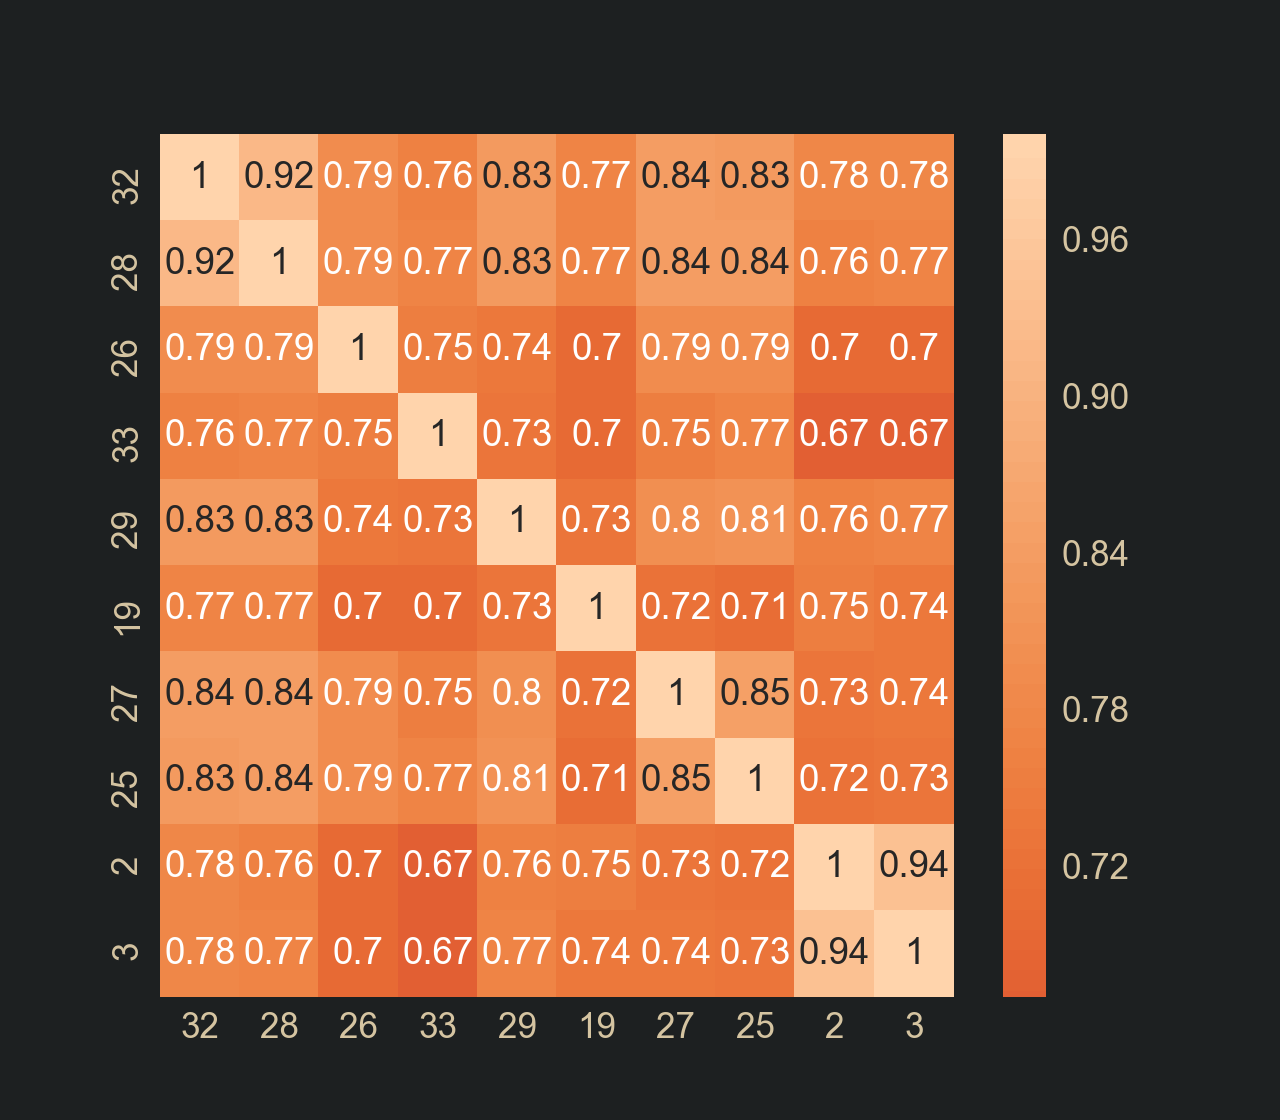

In [14]:
%matplotlib notebook

K_TOP = 10

top_results = {i: idx_results[i] for i in top.index[:K_TOP]}
ax = plot_corr_matrix(top_results)